**Imported Packages**

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 32.6 MB/s 
     |████████████████████████████████| 1.6 MB 46.0 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer
import keras_tuner as kt
from tensorflow.python import metrics


# Model Implementation

**Read file**

In [3]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/new_results.csv")

In [4]:
df.head()

,Unnamed: 0,Season,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,...,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,FTR_A,FTR_D,FTR_H,HTR_A,HTR_D,HTR_H
0,2091,2012-13,0,0,0,0,5,11,1,7,...,0,0,0,0,0,1,0,0,1,0
1,4407,2014-15,5,0,3,0,16,8,9,1,...,0,0,0,0,0,0,1,0,0,1
2,7459,2005-06,4,0,1,0,11,11,8,6,...,0,0,0,0,0,0,1,0,0,1
3,2832,2019-20,0,2,0,0,18,13,7,5,...,0,0,0,0,1,0,0,0,1,0
4,7214,2014-15,0,1,0,0,7,10,1,4,...,1,0,0,0,1,0,0,0,1,0


**Splitting data to feature and target**

In [5]:
feature=df.drop(["Season","N_FTR","Unnamed: 0"],axis = 1)
target=df["N_FTR"]

In [6]:
target

0       2
1       2
2       0
3       2
4       1
       ..
6801    2
6802    2
6803    1
6804    2
6805    0
Name: N_FTR, Length: 6806, dtype: int64

In [7]:
target=tf.keras.utils.to_categorical(target, num_classes=3)

In [8]:
target

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

**Spliting Data to train and test**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.20, random_state=1)

**change data type to tensor**

In [10]:
X_train=tf.convert_to_tensor(X_train)
y_train=tf.convert_to_tensor(y_train)

In [11]:
X_test=tf.convert_to_tensor(X_test)
y_test=tf.convert_to_tensor(y_test)

In [12]:
X_train.shape

TensorShape([5444, 102])

In [13]:
y_train.shape

TensorShape([5444, 3])

In [14]:
y_train

<tf.Tensor: shape=(5444, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [15]:
y_test

<tf.Tensor: shape=(1362, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

**Define Sequential model with 4 layers**

In [16]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(102,activation="relu",input_dim=102,name="input_layer"))
  hp_layer_2 = hp.Int("layer_2",min_value=1,max_value=100)
  hp_layer_3 = hp.Int("layer_3",min_value=1,max_value=100)


  model.add(tf.keras.layers.Dense(units=hp_layer_2,activation="relu",name="L2"))
  model.add(tf.keras.layers.Dense(units=hp_layer_3,activation="relu",name="L3"))

  model.add(tf.keras.layers.Dense(3,activation="softmax",name="output_layer"))

  model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=["accuracy"])


  return model

In [17]:
tuner =kt.Hyperband(model_builder,objective="val_accuracy",max_epochs=50)

In [18]:
stop_early= tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

In [19]:
from pandas.core.common import random_state
tuner.search(X_train,y_train,epochs=50,validation_split=0.2,callbacks=[stop_early])

Trial 90 Complete [00h 00m 04s]
val_accuracy: 0.516069769859314

Best val_accuracy So Far: 0.5381083488464355
Total elapsed time: 00h 06m 48s


In [20]:
best_hp=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp

In [21]:
model=tuner.hypermodel.build(best_hp)

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 102)               10506     
                                                                 
 L2 (Dense)                  (None, 95)                9785      
                                                                 
 L3 (Dense)                  (None, 16)                1536      
                                                                 
 output_layer (Dense)        (None, 3)                 51        
                                                                 
Total params: 21,878
Trainable params: 21,878
Non-trainable params: 0
_________________________________________________________________


In [23]:
history=model.fit(X_train,y_train,epochs=50,validation_split=0.2,callbacks=[stop_early],batch_size=10)

Epoch 1/50
436/436 [==============================] - 2s 3ms/step - loss: 1.0679 - accuracy: 0.4776 - val_loss: 1.0357 - val_accuracy: 0.5005
Epoch 2/50
436/436 [==============================] - 2s 3ms/step - loss: 1.0341 - accuracy: 0.4928 - val_loss: 1.0181 - val_accuracy: 0.5087
Epoch 3/50
436/436 [==============================] - 1s 3ms/step - loss: 1.0204 - accuracy: 0.5010 - val_loss: 1.0299 - val_accuracy: 0.4986
Epoch 4/50
436/436 [==============================] - 2s 3ms/step - loss: 1.0074 - accuracy: 0.5148 - val_loss: 1.0258 - val_accuracy: 0.5087
Epoch 5/50
436/436 [==============================] - 1s 3ms/step - loss: 0.9977 - accuracy: 0.5219 - val_loss: 1.0212 - val_accuracy: 0.5133


**model accuracy and loss graph**

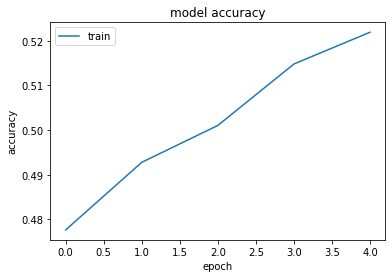

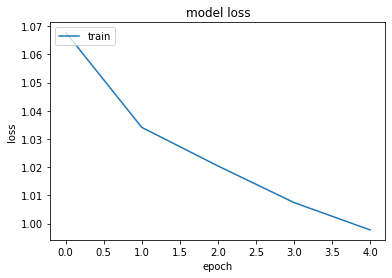

In [24]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

**test model**

In [25]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


43/43 [==============================] - 0s 2ms/step - loss: 1.0073 - accuracy: 0.5301
Test Score: 1.0073316097259521
Test Accuracy: 0.5301027894020081


In [26]:
pred=model.predict(X_test)
pred=np.argmax(pred,axis=1)
y_test=np.argmax(y_test,axis=1)

43/43 [==============================] - 0s 1ms/step


In [27]:
pred

array([2, 2, 2, ..., 2, 2, 2])

In [28]:
print("Home:2, Away:0, Draw:1")
for i in range(20):
  print(f"predected: {pred[i]},    expected: {y_test[i]}")

Home:2, Away:0, Draw:1
predected: 2,    expected: 2
predected: 2,    expected: 0
predected: 2,    expected: 0
predected: 0,    expected: 0
predected: 0,    expected: 2
predected: 0,    expected: 1
predected: 0,    expected: 1
predected: 2,    expected: 1
predected: 0,    expected: 0
predected: 0,    expected: 0
predected: 0,    expected: 0
predected: 0,    expected: 0
predected: 0,    expected: 0
predected: 2,    expected: 1
predected: 2,    expected: 1
predected: 0,    expected: 0
predected: 2,    expected: 2
predected: 0,    expected: 0
predected: 2,    expected: 1
predected: 2,    expected: 2
